Check what classification accuracy we can expect from 4-split with new structure. Should be worse, since reco loss saturates also at higher level. However, we get about 95% accuracy. (vgl. to 95.6% with prev. model)

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
#         self.regressor = self._create_regressor(latent_dim)
        self.classifier = self._create_classifier(latent_dim)
#         self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_pred = self.decode(z ,training=training)
        y_pred = self.classify(z ,training=training)
#         y_pred = self.regress(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='sigmoid', padding='same', name='pt_conv'),  # Introduce point convolution at end
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense((io_shape[0]-4)*(io_shape[1]-4)),
            Reshape((io_shape[0]-4,io_shape[1]-4,1)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=1, kernel_size=(1,1), padding='valid'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(2, activation='linear')
        ])

In [3]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

Epoch 1/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.8556 - acc: 0.7381 - val_loss: 0.4245 - val_acc: 0.8721
Epoch 2/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3992 - acc: 0.8766 - val_loss: 0.3485 - val_acc: 0.8900
Epoch 3/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3504 - acc: 0.8906 - val_loss: 0.3141 - val_acc: 0.9028
Epoch 4/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3232 - acc: 0.8989 - val_loss: 0.2910 - val_acc: 0.9080
Epoch 5/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3042 - acc: 0.9050 - val_loss: 0.2773 - val_acc: 0.9124
Epoch 6/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2905 - acc: 0.9082 - val_loss: 0.2628 - val_acc: 0.9159
Epoch 7/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2798 - acc: 0.9117 - val_loss: 0.2594 - val_acc: 0.9211
Epoch 8/100
1875/1875 [==============================] 

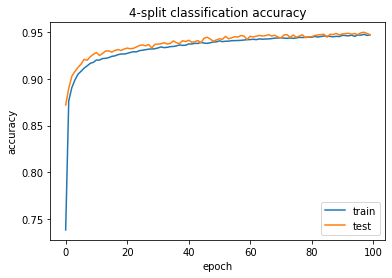

In [3]:
model = MultiSplit(n_splits, latent_dim, io_shape)

model.encoder.load_weights('../weights/31_CE4x4_epoch50.h5')
for layer in model.encoder.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=100, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('4-split classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
#         self.regressor = self._create_regressor(latent_dim)
        self.classifier = self._create_classifier(latent_dim)
#         self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_pred = self.decode(z ,training=training)
        y_pred = self.classify(z ,training=training)
#         y_pred = self.regress(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
#             Conv2D(filters=n_filters[0], kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'),
#             Conv2D(filters=n_filters[1], kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'),
#             Conv2D(filters=n_filters[1]*2, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='relu', padding='valid', name='pt_conv'),  # Introduce point convolution at end
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense((io_shape[0]-4)*(io_shape[1]-4)),
            Reshape((io_shape[0]-4,io_shape[1]-4,1)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=1, kernel_size=(1,1), padding='valid'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(2, activation='linear')
        ])

In [2]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0838 - acc: 0.9725 - val_loss: 0.1148 - val_acc: 0.9642
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0785 - acc: 0.9740 - val_loss: 0.1087 - val_acc: 0.9689
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0753 - acc: 0.9750 - val_loss: 0.1099 - val_acc: 0.9676
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0715 - acc: 0.9764 - val_loss: 0.1039 - val_acc: 0.9675
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0690 - acc: 0.9773 - val_loss: 0.1058 - val_acc: 0.9683
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0644 - acc: 0.9786 - val_loss: 0.1072 - val_acc: 0.9688
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0622 - acc: 0.9793 - val_loss: 0.1182 - val_acc: 0.9667
Epoch 8/10
1875/1875 [==============================] - 5s 3ms

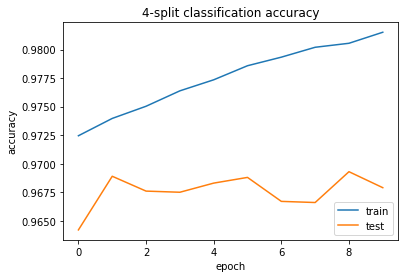

In [5]:
model = MultiSplit(n_splits, latent_dim, io_shape)

# model.encoder.load_weights('../weights/31_CE4x4_epoch50.h5')
# for layer in model.encoder.layers:
#     layer.trainable = False

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=10, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('4-split classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()